In [50]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [30]:
# Define the base directory for processed data
base_output_folder = '../data/processed/'
augmented_output_folder = '../data/processed_augmented/'

In [31]:
# Data augmentation and normalization
datagen = ImageDataGenerator(
    validation_split=0.2  # Using 20% of the data for validation
)

In [32]:
# Prepare the data generators
train_generator = datagen.flow_from_directory(
    base_output_folder,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=['1', '2', '3']  # Specify the classes explicitly
)

Found 2452 images belonging to 3 classes.


In [33]:
validation_generator = datagen.flow_from_directory(
    base_output_folder,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=['1', '2', '3']  # Specify the classes explicitly
)

Found 612 images belonging to 3 classes.


In [34]:
# Print class indices to verify classes
print("Class indices:", train_generator.class_indices)

Class indices: {'1': 0, '2': 1, '3': 2}


In [57]:
# Define the model using Sequential API with L2 regularization and adjust dropout rate
model = Sequential([
    Input(shape=(256, 256, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.7),  # Increase this to 0.6 or 0.7 if needed
    Dense(3, activation='softmax', kernel_regularizer=l2(0.05))  # Three classes for the three tumor types
])

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Define the model directory
model_output_folder = '../models/'

In [39]:
# Create the directory if it doesn't exist
if not os.path.exists(model_output_folder):
    os.makedirs(model_output_folder)

# Define callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_output_folder, 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

In [63]:
# Define a learning rate scheduler with a more gradual decrease
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.05 * epoch))

lr_scheduler = LearningRateScheduler(scheduler)

In [64]:
# Train the model with the new callback
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 35s 447ms/step - accuracy: 0.5397 - loss: 35.4662 - val_accuracy: 0.6879 - val_loss: 3.9207 - learning_rate: 0.0010
Epoch 2/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 430ms/step - accuracy: 0.7577 - loss: 3.5556 - val_accuracy: 0.7124 - val_loss: 3.1316 - learning_rate: 9.5123e-04
Epoch 3/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 427ms/step - accuracy: 0.8218 - loss: 2.8219 - val_accuracy: 0.7173 - val_loss: 2.6288 - learning_rate: 8.6071e-04
Epoch 4/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.8434 - loss: 2.3407 - val_accuracy: 0.7876 - val_loss: 2.2379 - learning_rate: 7.4082e-04
Epoch 5/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.8771 - loss: 1.9885 - val_accuracy: 0.7271 - val_loss: 2.1093 - learning_rate: 6.0653e-04
Epoch 6/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 426ms/step - accuracy: 0.8941 - loss: 1.7660 - val_accuracy: 0.7010 - val_loss: 2.1795 - learning_rate: 4.7237e-04
Epoch 7/25
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 429ms/step - accura

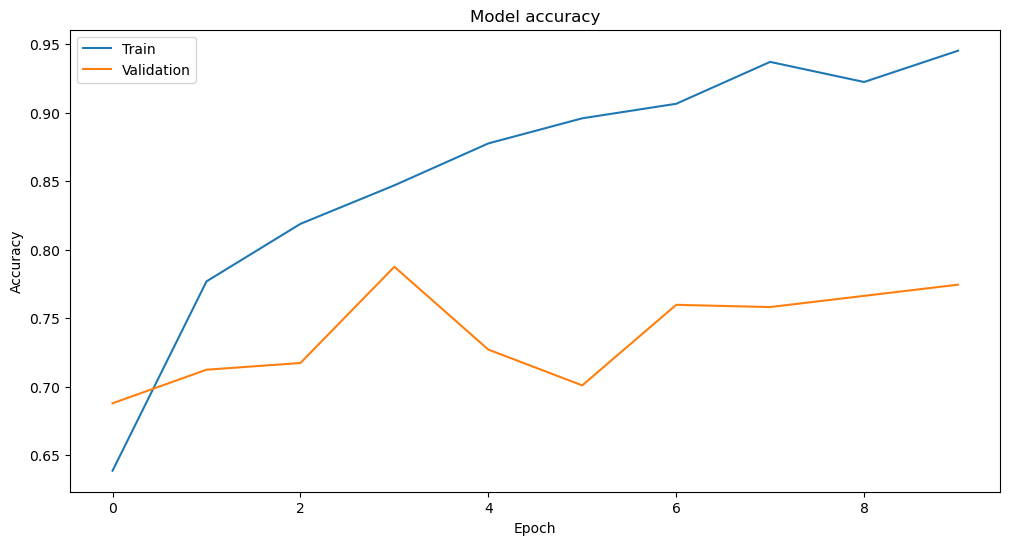

In [65]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

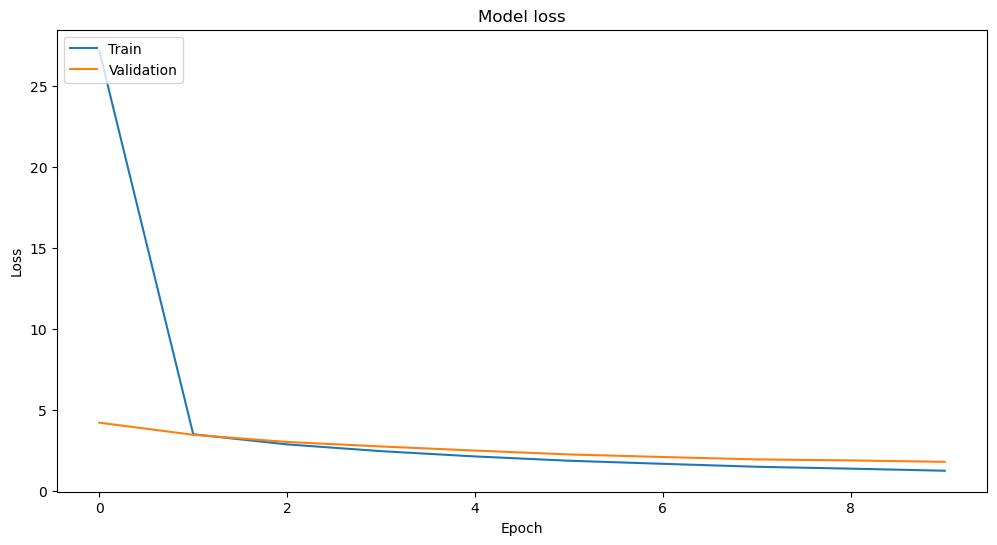

In [54]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# Save training history to a CSV file
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(model_output_folder, 'training_history.csv'), index=False)

# Save the final model
model.save(os.path.join(model_output_folder, 'final_model.keras'))